In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from msresist.pre_processing import filter_NaNpeptides
from msresist.clustering import MassSpecClustering
from msresist.figures.figure2 import plotDistanceToUpstreamKinase
from msresist.figures.figureM4 import find_patients_with_NATandTumor
from msresist.figures.figureM5 import plot_clusters_binaryfeatures, build_pval_matrix, calculate_mannW_pvals
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from msresist.logistic_regression import plotROC, plotClusterCoefficients

In [3]:
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [145]:
X = filter_NaNpeptides(pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:], tmt=2)
d = X.select_dtypes(include=[float]).T
i = X.select_dtypes(include=[object])

In [5]:
model = MassSpecClustering(i, ncl=30, SeqWeight=100, distance_method="Binomial", random_state=7).fit(d)

In [6]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv")
mOI = mutations[["Sample.ID"] + list(mutations.columns)[45:54] + list(mutations.columns)[61:64]]
y = mOI[~mOI["Sample.ID"].str.contains("IR")]

In [62]:
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.n_components) + 1
centers["Patient_ID"] = X.columns[4:]
centers = centers.set_index("Patient_ID")
centers = centers.drop(19, axis=1)  # Drop cluster 19, contains only 1 peptide

In [8]:
# assert np.all(y['Sample.ID'] == centers.index)
# centers["STK11"] = y["STK11.mutation.status"].values
# pvals = calculate_mannW_pvals(centers, "STK11", 1, 0)
# pvals = build_pval_matrix(model.n_components, pvals)
# centers["STK11"] = centers["STK11"].replace(0, "STK11 WT")
# centers["STK11"] = centers["STK11"].replace(1, "STK11m")

# _, ax = plt.subplots(1, 1, figsize=(10, 5))
# plot_clusters_binaryfeatures(centers, "STK11", ax, pvals=pvals)
# ax.legend(loc='lower left', prop={'size': 10})

In [55]:
# centers["KRAS"] = y["KRAS.mutation.status"].values
# pvals = calculate_mannW_pvals(centers, "KRAS", 1, 0)
# pvals = build_pval_matrix(model.n_components, pvals)
# centers["KRAS"] = centers["KRAS"].replace(0, "KRAS WT")
# centers["KRAS"] = centers["KRAS"].replace(1, "KRASm")

# _, ax = plt.subplots(1, 1, figsize=(10, 5))
# plot_clusters_binaryfeatures(centers, "KRAS", ax, pvals=pvals)
# ax.legend(loc='lower left', prop={'size': 10})

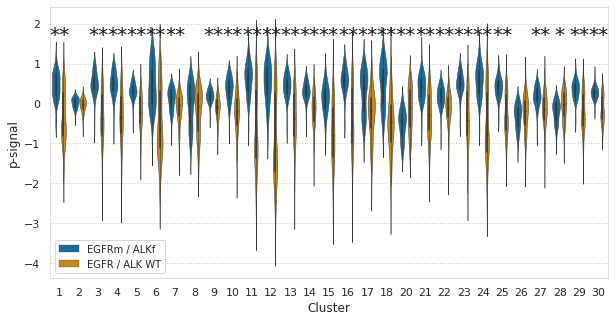

In [63]:
from msresist.figures.figureM4 import merge_binary_vectors

centers["EGFRm/ALKf"] = merge_binary_vectors(y, "EGFR.mutation.status", "ALK.fusion").values
pvals = calculate_mannW_pvals(centers, "EGFRm/ALKf", 1, 0)
pvals = build_pval_matrix(model.n_components, pvals)
centers["EGFRm/ALKf"] = centers["EGFRm/ALKf"].replace(0, "EGFR / ALK WT")
centers["EGFRm/ALKf"] = centers["EGFRm/ALKf"].replace(1, "EGFRm / ALKf")

_, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_clusters_binaryfeatures(centers, "EGFRm/ALKf", ax, pvals=pvals)
ax.legend(loc='lower left', prop={'size': 10})

In [64]:
# Reshape data (Patients vs NAT and tumor sample per cluster)
centers = centers.reset_index().set_index("EGFRm/ALKf")
centers = find_patients_with_NATandTumor(centers, "Patient_ID", conc=True)
y_ = find_patients_with_NATandTumor(y.copy(), "Sample.ID", conc=False)
assert all(centers.index.values == y_.index.values), "Samples don't match"

In [65]:
# Normalize
centers = centers.T
centers.iloc[:, :] = StandardScaler(with_std=False).fit_transform(centers.iloc[:, :])
centers = centers.T

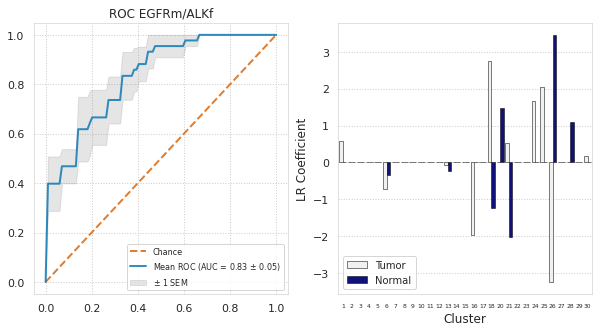

In [101]:
from sklearn.svm import SVC

# Logistic Regression
centers["EGFRm/ALKf"] = merge_binary_vectors(y_, "EGFR.mutation.status", "ALK.fusion").values
lr = LogisticRegressionCV(cv=15, solver="saga", max_iter=10000, n_jobs=-1, penalty="elasticnet", l1_ratios=[0.95, 0.83], class_weight="balanced", random_state=0)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotROC(ax[0], lr, centers.iloc[:, :-1].values, centers["EGFRm/ALKf"], cv_folds=4, title="ROC EGFRm/ALKf")
ax[0].legend(loc='lower right', prop={'size': 8})
plotClusterCoefficients(ax[1], lr.fit(centers.iloc[:, :-1].values, centers["EGFRm/ALKf"]), list(centers.columns[:-1]), title="")
ax[1].legend(loc='lower left', prop={'size': 10})

/home/marcc/resistance-MS/msresist/clustering.py:170: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/home/marcc/resistance-MS/msresist/clustering.py:186: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/home/marcc/resistance-MS/msresist/clustering.py:170: RuntimeWarning: invalid value encountered in true_divide
  pssm /= back_pssm.copy()
/home/marcc/resistance-MS/msresist/clustering.py:186: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


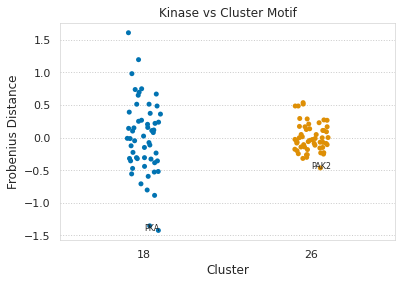

In [102]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))
plotDistanceToUpstreamKinase(model, [18, 26], ax, num_hits=1, PsP_background=False)

querying 1-8...done.
Finished.
querying 1-31...done.
Finished.
querying 1-8...done.
Finished.
querying 1-15...done.
Finished.
querying 1-21...done.
Finished.
querying 1-36...done.
Finished.
querying 1-8...done.
Finished.
querying 1-12...done.
Finished.
querying 1-10...done.
Finished.
querying 1-8...done.
Finished.
querying 1-21...done.
Finished.
querying 1-11...done.
Finished.
querying 1-8...done.
Finished.
querying 1-10...done.
Finished.
querying 1-12...done.
Finished.
querying 1-8...done.
Finished.
querying 1-15...done.
Finished.
querying 1-10...done.
Finished.
querying 1-13...done.
Finished.
querying 1-9...done.
Finished.
querying 1-10...done.
Finished.
querying 1-11...done.
Finished.
querying 1-10...done.
Finished.
querying 1-8...done.
Finished.


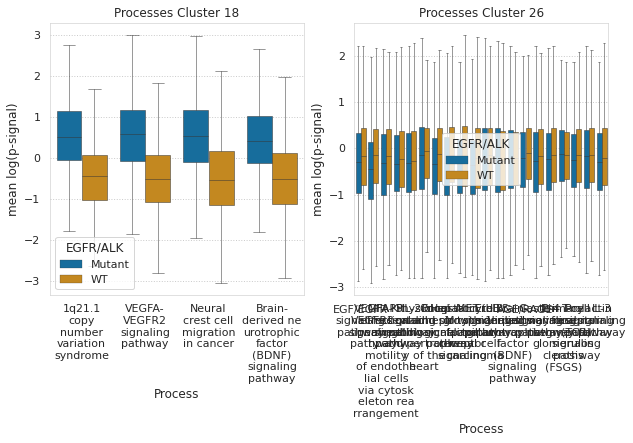

In [159]:
import textwrap
from msresist.figures.figureM5 import make_BPtoGenes_table

def plot_enriched_processes(ax, X, y, f, cluster, gene_set="WP"):
    """"Plot BPs enriched per cluster"""""
    if gene_set == "WP":
        gsea = pd.read_csv("msresist/data/cluster_analysis/CPTAC_GSEA_WP_results.csv").iloc[:, 1:]
    elif gene_set == "onco":
        gsea = pd.read_csv("msresist/data/cluster_analysis/CPTAC_GSEA_ONCO_results.csv").iloc[:, 1:]
    elif gene_set == "Immuno":
        gsea = pd.read_csv("msresist/data/cluster_analysis/CPTAC_GSEA_WP_results.csv").iloc[:, 1:]
    cc = make_BPtoGenes_table(gsea, cluster)
    cl = X[X["Cluster"] == cluster].set_index("Gene")
    dfs = []
    for ii in range(cc.shape[1]):
        ss = cl.loc[cc.iloc[:, ii].dropna()].reset_index()
        ss["Process"] = cc.columns[ii]
        dfs.append(ss)

    out = pd.concat(dfs).set_index("Process").select_dtypes(include=[float]).T
    out[f[0]] = y
    out[f[0]] = out[f[0]].replace(0, f[1])
    out[f[0]] = out[f[0]].replace(1, f[2])
    dm = pd.melt(out, id_vars=f[0], value_vars=out.columns, var_name="Process", value_name="mean log(p-signal)")
    dm.iloc[:, -1] = dm.iloc[:, -1].astype(float)
    sns.boxplot(data=dm, x="Process", y="mean log(p-signal)", hue=f[0], showfliers=False, linewidth=0.5, ax=ax)
    ax.set_xticklabels([textwrap.fill(t, 10) for t in list(cc.columns)], rotation=0)
    ax.set_title("Processes Cluster " + str(cluster))


# X = X.loc[:, ["Gene"] + list(centers.index)]
X["Cluster"] = model.labels()
yEA = merge_binary_vectors(y, "EGFR.mutation.status", "ALK.fusion").values
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_enriched_processes(ax[0], X, yEA, ["EGFR/ALK", "WT", "Mutant"], 18, gene_set="WP")
plot_enriched_processes(ax[1], X, yEA, ["EGFR/ALK", "WT", "Mutant"], 26, gene_set="WP")

In [164]:
def plot_enriched_processes(ax, X, y, f, cluster, gene_set="WP"):
    """"Plot BPs enriched per cluster"""""
    if gene_set == "WP":
        gsea = pd.read_csv("msresist/data/cluster_analysis/CPTAC_GSEA_WP_results.csv").iloc[:, 1:]
    elif gene_set == "onco":
        gsea = pd.read_csv("msresist/data/cluster_analysis/CPTAC_GSEA_ONCO_results.csv").iloc[:, 1:]
    elif gene_set == "Immuno":
        gsea = pd.read_csv("msresist/data/cluster_analysis/CPTAC_GSEA_WP_results.csv").iloc[:, 1:]
    cc = make_BPtoGenes_table(gsea, cluster)
    cl = X[X["Cluster"] == cluster].set_index("Gene")
    dfs = []
    for ii in range(cc.shape[1]):
        ss = cl.loc[cc.iloc[:, ii].dropna()].reset_index()
        ss["Process"] = cc.columns[ii]
        dfs.append(ss)

    out = pd.concat(dfs).set_index(["Process", "Gene", "Position"]).select_dtypes(include=[float]).T
    out[f[0]] = y
    out[f[0]] = out[f[0]].replace(0, f[1])
    out[f[0]] = out[f[0]].replace(1, f[2])
    return out

out = plot_enriched_processes(ax[1], X, yEA, ["EGFR/ALK", "WT", "Mutant"], 26, gene_set="WP")

querying 1-21...done.
Finished.
querying 1-36...done.
Finished.
querying 1-8...done.
Finished.
querying 1-12...done.
Finished.
querying 1-10...done.
Finished.
querying 1-8...done.
Finished.
querying 1-21...done.
Finished.
querying 1-11...done.
Finished.
querying 1-8...done.
Finished.
querying 1-10...done.
Finished.
querying 1-12...done.
Finished.
querying 1-8...done.
Finished.
querying 1-15...done.
Finished.
querying 1-10...done.
Finished.
querying 1-13...done.
Finished.
querying 1-9...done.
Finished.
querying 1-10...done.
Finished.
querying 1-11...done.
Finished.
querying 1-10...done.
Finished.
querying 1-8...done.
Finished.


In [225]:
out = out[~out.index.str.endswith(".N")]
dd = out.reset_index().drop("index", axis=1).set_index("EGFR/ALK").sort_index()
egfr = dd.iloc[:, dd.columns.get_level_values(0)==list(set(dd.columns.get_level_values(0)))[1]]

<AxesSubplot:xlabel='Process-Gene-Position', ylabel='EGFR/ALK'>

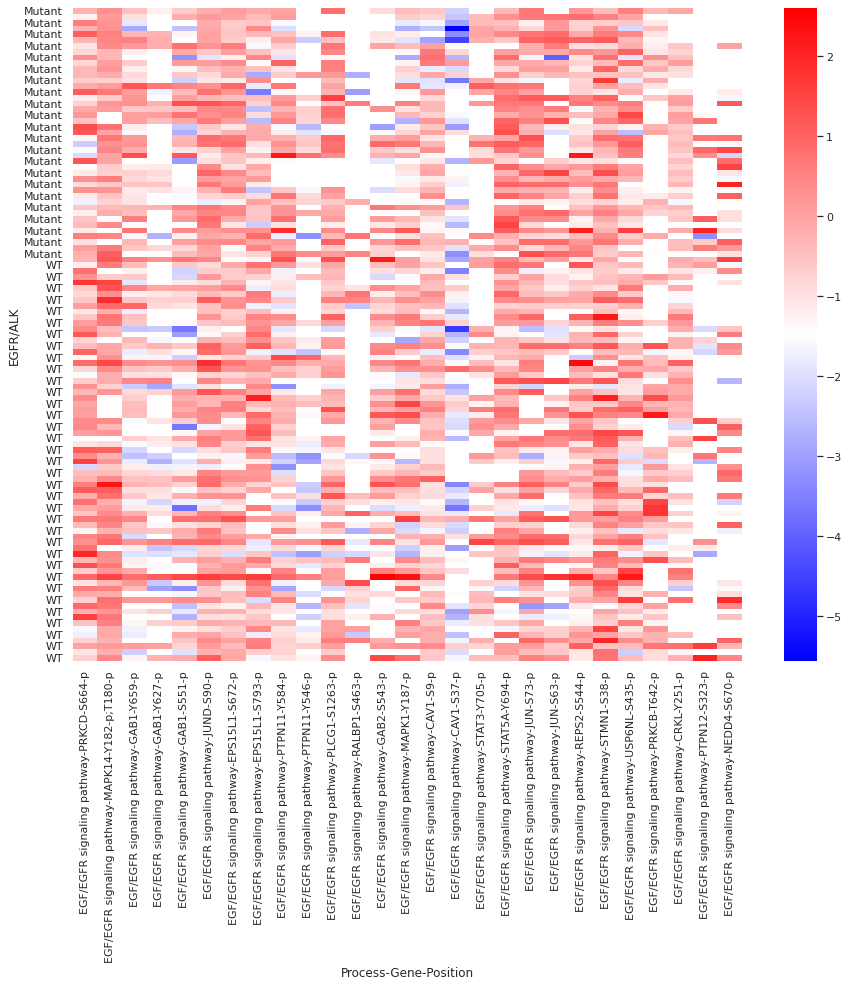

In [226]:
_, ax =plt.subplots(1, 1, figsize=(15, 12))
sns.heatmap(egfr, ax=ax, cmap="bwr")